In [11]:
import requests
import matplotlib.pyplot as plt

In [12]:
def get_bls_data(series_id, start_year, end_year, api_key):
    """
    Fetch data from the BLS API for the given series ID and year.
    """
    url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
    headers = {
        'Content-Type': 'application/json'
    }
    params = {
        "seriesid": [series_id],
        "startyear": start_year,
        "endyear": end_year,
        "catalog": "true",
        "calculations": "true",
        "annualaverage": "true",
        "registrationkey": api_key
    }

    try:
        response = requests.post(url, json=params, headers=headers)
        response.raise_for_status()
        data = response.json()
        # Extracting the annual average value
        return float(data['Results']['series'][0]['data'][0]['value'])
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        return None
    except requests.exceptions.RequestException as err:
        print(f"Error occurred: {err}")
        return None
    except (KeyError, IndexError) as json_err:
        print(f"Error retrieving data from BLS API: {json_err}")
        return None

In [13]:
def transform_data(housing, transportation, food, healthcare):
    """
    Transform raw data values into percentages for each category.
    Normalize them so they can be applied as percentages to income.
    """
    total_raw = housing + transportation + food + healthcare

    # Transform each value to a percentage of the total
    housing_percent = housing / total_raw
    transportation_percent = transportation / total_raw
    food_percent = food / total_raw
    healthcare_percent = healthcare / total_raw

    return housing_percent, transportation_percent, food_percent, healthcare_percent

In [14]:
def analyze_budget(income, housing_percent, transportation_percent, food_percent, healthcare_percent, savings_percent, misc_percent):
    """
    Analyze the budget by calculating expenditures in each category
    and ensuring they fit within the income. 
    """
    # Reserve income for savings and miscellaneous
    reserved_for_savings_misc = income * (savings_percent + misc_percent)
    
    # Remaining income for essential expenses
    remaining_income = income - reserved_for_savings_misc

    # Calculate expenses
    housing = remaining_income * housing_percent
    transportation = remaining_income * transportation_percent
    food = remaining_income * food_percent
    healthcare = remaining_income * healthcare_percent

    # Calculate savings and misc
    savings = income * savings_percent
    misc = income * misc_percent

    # Total expenses
    total_expenses = housing + transportation + food + healthcare + savings + misc

    # Data Analysis: Show analysis results
    print("\nAnalysis:")
    print(f"Housing takes up {housing_percent*100:.2f}% of your remaining income.")
    print(f"Transportation takes up {transportation_percent*100:.2f}% of your remaining income.")
    print(f"Food takes up {food_percent*100:.2f}% of your remaining income.")
    print(f"Healthcare takes up {healthcare_percent*100:.2f}% of your remaining income.")

    # Output the budget
    print("\nBudget based on an income of ${:,}".format(income))
    print("Housing: ${:,}".format(housing))
    print("Transportation: ${:,}".format(transportation))
    print("Food: ${:,}".format(food))
    print("Healthcare: ${:,}".format(healthcare))
    print("Savings: ${:,}".format(savings))
    print("Miscellaneous: ${:,}".format(misc))
    print("\nTotal Expenses: ${:,}".format(total_expenses))

    # Check if the budget balances
    if total_expenses > income:
        print("Warning: Expenditures exceed income by ${:,}!".format(total_expenses - income))
    else:
        print("Your budget balances perfectly!")

    # Create a pie chart without surplus
    create_pie_chart(housing, transportation, food, healthcare, savings, misc, income)

In [15]:
def create_pie_chart(housing, transportation, food, healthcare, savings, misc, income):
    """
    Create a pie chart that shows the proportion of income spent on different categories, with both money amount and percentage displayed.
    """
    labels = ['Housing', 'Transportation', 'Food', 'Healthcare', 'Savings', 'Miscellaneous']
    sizes = [housing, transportation, food, healthcare, savings, misc]
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
    
    def func(pct, allvalues):
        absolute = int(pct/100.*sum(allvalues))
        return f"{pct:.1f}%\n${absolute:,.0f}"

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: func(pct, sizes), startangle=90)
    plt.title(f'Budget Allocation for an Income of ${income:,.0f}')
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
    plt.show()


In [16]:
# Example BLS series IDs for various expenditure categories
housing_series_id = "CUUR0000SAH"  
transportation_series_id = "CUUR0000SAT"  
food_series_id = "CUUR0000SAF"  
healthcare_series_id = "CUUR0000SAM"  



In [20]:
# Define your API key
api_key = "64519766a7fe4ada8bbee4a7c56461d1"


Analysis:
Housing takes up 21.98% of your remaining income.
Transportation takes up 18.33% of your remaining income.
Food takes up 22.00% of your remaining income.
Healthcare takes up 37.69% of your remaining income.

Budget based on an income of $200,000.0
Housing: $30,770.51077693616
Transportation: $25,658.23815388248
Food: $30,800.880332692162
Healthcare: $52,770.370736489174
Savings: $20,000.0
Miscellaneous: $40,000.0

Total Expenses: $200,000.0
Your budget balances perfectly!


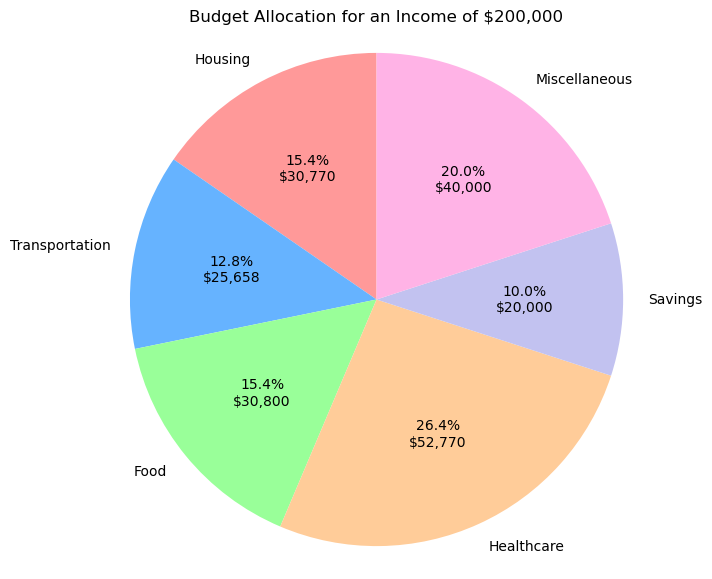

In [19]:
# Define the income
try:
    income = float(input("Enter your annual income: $"))
    savings_percent = float(input("Enter the percentage of income for savings (e.g., 0.15 for 15%): "))
    misc_percent = float(input("Enter the percentage of income for miscellaneous (e.g., 0.10 for 10%): "))

    # Fetching the expenditure percentages from the BLS API
    housing = get_bls_data(housing_series_id, "2023", "2023", api_key)
    transportation = get_bls_data(transportation_series_id, "2023", "2023", api_key)
    food = get_bls_data(food_series_id, "2023", "2023", api_key)
    healthcare = get_bls_data(healthcare_series_id, "2023", "2023", api_key)
    
    # Check if we successfully fetched the data
    if None not in [housing, transportation, food, healthcare]:
        # Data Transformation: Convert raw values to percentages of income
        housing_percent, transportation_percent, food_percent, healthcare_percent = transform_data(housing, transportation, food, healthcare)

        # Data Analysis: Analyze and calculate the budget and check for the surplus
        analyze_budget(income, housing_percent, transportation_percent, food_percent, healthcare_percent, savings_percent, misc_percent)
    else:
        print("Failed to retrieve all required data from the BLS API.")

except ValueError:
    print("Please enter valid numbers for income, savings, and miscellaneous percentages.")